# Evaluation of the `HaGraD`-Optimizer on an NLP Sentiment Analysis Task

Guidance by [this](https://www.tensorflow.org/text/tutorials/text_classification_rnn) article.

---

## Imports and Data-Preparation

In [1]:
## Tensorflow related
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## General
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Hagrad custom optimizer
import sys; 
if "..\\" not in sys.path: sys.path.append("..\\")
from src.hagrad import Hagrad
from src.kinetic_energy_gradients import KineticEnergyGradients

g:\miniconda3\envs\tensorflow-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Fetch IMDB-Reviews Text Classification Dataset
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
print("Dataset specs:")
print(train_dataset.element_spec)

print("\nExample instance:")
for example, label in train_dataset.take(1):
  print('text: ', example.numpy()[:38])
  print('label: ', label.numpy())

Dataset specs:
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))

Example instance:
text:  b'This was an absolutely terrible movie.'
label:  0


In [3]:
## Data Preprocessing
buffer_size = 10000
batch_size  = 64
train_dataset = (train_dataset.shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


vocab_size = 1000
encoder = layers.TextVectorization(
    max_tokens=vocab_size)
encoder.adapt(train_dataset.map(lambda text, label: text))

---

## Defining Model generating function

Convnet inspired by https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/.

In [4]:
def bidir_LSTM(
    optimizer: keras.optimizers.Optimizer,
    print_summary: bool=False,
    encoder: keras.layers.Layer=encoder) -> keras.Model:

    ## Defining the Model with Sequential API
    model = keras.Sequential([
        encoder,
        layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=64,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        layers.Bidirectional(tf.keras.layers.LSTM(64)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    ## Compiling the Model using the given Optimizer
    model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits=True), 
        optimizer=optimizer, 
        metrics=["accuracy"])

    ## Optional: Print Model summary
    if print_summary: print(model.summary())

    return model


---

## Train the Network using different Optimizers

In [5]:
## Settings
epochs = 10
validation_steps = 30

In [6]:
## Wrappers
def model_optimizer(optimizer):
    model = bidir_LSTM(
        optimizer=optimizer,
        print_summary=False)
    return model

def model_fit(model, verbose=2):
    fit = model.fit(
        train_dataset,
        epochs=epochs, 
        validation_data=test_dataset, 
        validation_steps=validation_steps,
        verbose=verbose)
    return fit

#### Adam

In [7]:
keras.backend.clear_session()
model_adam = model_optimizer(keras.optimizers.Adam(1e-4))
fit_adam = model_fit(model_adam)

Epoch 1/10
391/391 - 54s - loss: 0.6630 - accuracy: 0.5385 - val_loss: 0.5839 - val_accuracy: 0.7156
Epoch 2/10
391/391 - 42s - loss: 0.4179 - accuracy: 0.8019 - val_loss: 0.3638 - val_accuracy: 0.8417
Epoch 3/10
391/391 - 43s - loss: 0.3435 - accuracy: 0.8490 - val_loss: 0.3356 - val_accuracy: 0.8443
Epoch 4/10
391/391 - 42s - loss: 0.3223 - accuracy: 0.8582 - val_loss: 0.3248 - val_accuracy: 0.8630
Epoch 5/10
391/391 - 42s - loss: 0.3115 - accuracy: 0.8639 - val_loss: 0.3191 - val_accuracy: 0.8609
Epoch 6/10
391/391 - 42s - loss: 0.3067 - accuracy: 0.8664 - val_loss: 0.3202 - val_accuracy: 0.8609
Epoch 7/10
391/391 - 42s - loss: 0.3012 - accuracy: 0.8689 - val_loss: 0.3334 - val_accuracy: 0.8292
Epoch 8/10
391/391 - 42s - loss: 0.3016 - accuracy: 0.8703 - val_loss: 0.3181 - val_accuracy: 0.8630
Epoch 9/10
391/391 - 41s - loss: 0.2975 - accuracy: 0.8724 - val_loss: 0.3320 - val_accuracy: 0.8641
Epoch 10/10
391/391 - 40s - loss: 0.2951 - accuracy: 0.8726 - val_loss: 0.3124 - val_accura

### SGD

In [8]:
keras.backend.clear_session()
model_sgd = model_optimizer(keras.optimizers.SGD(1., 0.1, True))
fit_sgd = model_fit(model_sgd)

Epoch 1/10
391/391 - 51s - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.4917
Epoch 2/10
391/391 - 41s - loss: 0.6921 - accuracy: 0.5011 - val_loss: 0.6875 - val_accuracy: 0.4917
Epoch 3/10
391/391 - 41s - loss: 0.6819 - accuracy: 0.5204 - val_loss: 0.6853 - val_accuracy: 0.6250
Epoch 4/10
391/391 - 42s - loss: 0.6643 - accuracy: 0.5666 - val_loss: 0.5997 - val_accuracy: 0.6771
Epoch 5/10
391/391 - 40s - loss: 0.6251 - accuracy: 0.6305 - val_loss: 0.5450 - val_accuracy: 0.7302
Epoch 6/10
391/391 - 41s - loss: 0.5734 - accuracy: 0.6773 - val_loss: 0.5318 - val_accuracy: 0.7599
Epoch 7/10
391/391 - 41s - loss: 0.4636 - accuracy: 0.7682 - val_loss: 0.4966 - val_accuracy: 0.6443
Epoch 8/10
391/391 - 42s - loss: 0.3617 - accuracy: 0.8318 - val_loss: 0.3370 - val_accuracy: 0.8354
Epoch 9/10
391/391 - 41s - loss: 0.3251 - accuracy: 0.8552 - val_loss: 0.4397 - val_accuracy: 0.8068
Epoch 10/10
391/391 - 40s - loss: 0.3050 - accuracy: 0.8672 - val_loss: 0.3139 - val_accura

### HaGraD

In [9]:
keras.backend.clear_session()
hagrad_optimizer = Hagrad(
    epsilon=10.,
    gamma=10.,
    p0_mean=0.,
    kinetic_energy_gradient=KineticEnergyGradients.classical())
print(hagrad_optimizer.get_config())
model_hagrad = model_optimizer(hagrad_optimizer)
fit_hagrad = model_fit(model_hagrad)

{'name': 'hagrad', 'epsilon': 10.0, 'gamma': 10.0, 'delta': 0.009900990099009901, 'kinetic_energy_gradient': 'Classical kinetic energy ||p||^2/2 with gradient p.'}
Epoch 1/10
391/391 - 51s - loss: 0.7214 - accuracy: 0.5010 - val_loss: 0.6958 - val_accuracy: 0.4917
Epoch 2/10
391/391 - 40s - loss: 0.6901 - accuracy: 0.5079 - val_loss: 0.6866 - val_accuracy: 0.4922
Epoch 3/10
391/391 - 41s - loss: 0.6816 - accuracy: 0.5285 - val_loss: 0.6692 - val_accuracy: 0.6208
Epoch 4/10
391/391 - 41s - loss: 0.6636 - accuracy: 0.5677 - val_loss: 0.6369 - val_accuracy: 0.6771
Epoch 5/10
391/391 - 41s - loss: 0.5974 - accuracy: 0.6606 - val_loss: 0.5616 - val_accuracy: 0.7677
Epoch 6/10
391/391 - 40s - loss: 0.4356 - accuracy: 0.7917 - val_loss: 0.4074 - val_accuracy: 0.7474
Epoch 7/10
391/391 - 41s - loss: 0.3393 - accuracy: 0.8458 - val_loss: 0.3612 - val_accuracy: 0.8651
Epoch 8/10
391/391 - 41s - loss: 0.3051 - accuracy: 0.8632 - val_loss: 0.3250 - val_accuracy: 0.8599
Epoch 9/10
391/391 - 40s - l

---

## Visualizing

Keras is evaluating the validation error at the end of each epoch. Therefore teh validation errors get shifted for the visualization:

In [10]:
epochs_arr = np.arange(epochs)
epochs_arr_val = epochs_arr + 1

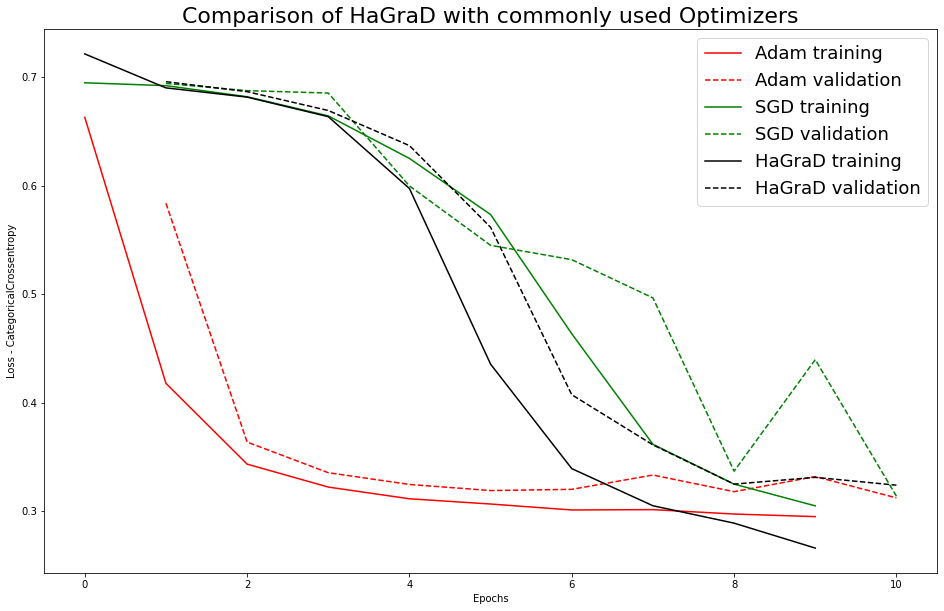

In [11]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Comparison of HaGraD with commonly used Optimizers", fontsize=22)
ax.plot(epochs_arr,     fit_adam.history['loss'],       "r-",  label="Adam training") 
ax.plot(epochs_arr_val, fit_adam.history['val_loss'],   "r--", label="Adam validation") 
ax.plot(epochs_arr,     fit_sgd.history['loss'],        "g-",  label="SGD training") 
ax.plot(epochs_arr_val, fit_sgd.history['val_loss'],    "g--", label="SGD validation") 
ax.plot(epochs_arr,     fit_hagrad.history['loss'],     "k-",  label="HaGraD training") 
ax.plot(epochs_arr_val, fit_hagrad.history['val_loss'], "k--", label="HaGraD validation") 
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss - CategoricalCrossentropy")
leg = ax.legend(frameon=True, fontsize=18)
plt.show()
plt.close()

---